Decision Tree Act Math with proficent score as label

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, confusion_matrix,f1_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


In [29]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
filename3 = os.path.join(os.getcwd(),"dataframes", "actMath_11.csv")
actMath_11_df = pd.read_csv(filename3, header = 0)


In [30]:
actMath_11_df.head(10)

,studentId,is_proficient,proficient_score,course_ACT Review,course_ACT/WK Rev.,course_ACTReview.5C,course_AG Communica,course_AIDE-ELEM,course_AIDE-LIB,course_ALG I B ACCE,course_ALIITRIGH/A,course_ARMY LET I,course_ARMY LET II,course_ARMY LET III,course_ARMY LET IV,course_ARMYLETIVACT,course_AcAdv.Baseba,course_AcAdv.Basket,course_AcAdv.CrossC,course_AcAdv.Footb,course_AcAdv.Softba,course_AcAdv.Volley,course_Accounting,course_Adv BTA,course_Advanced Agr,course_Agriscience,course_Alg Esntls B,course_Alg II/Trig,course_AlgEnrichmet,course_AlgII/TrigAC,course_Algebra I,course_Algebra I A,course_Algebra I B,course_Algebra II,course_AlgebraicCon,course_Anat/Physio,course_Anthropology,course_Art App,course_BAND MARCH,course_BANDCONCERT,course_BANDMARCHAUX,course_BIOLOGY ADV,course_Bak & Pstr A,course_BandConcer.5,course_BandConcer1C,course_BandMarch.5C,course_BandSymph 1C,course_Biology,course_Biology Adv,course_BullBogAdv,course_BulldogAdvi,course_Bus Finance,course_Bus Tech App,course_CABINETMAK I,course_CABINETMAKII,course_Cabntmkng I,course_Cabntmkng II,course_Career Prep,course_CareerPrep-A,course_CareerPrep-B,course_Chemistry,course_ChemistryAdv,course_Const Fin In,course_Const Frmng,course_ContempIss1C,course_Crea Writing,course_CreatWrt.5C,course_Credit Recov,course_Culinary I,course_Culinary II,course_D&TSafetyEd,course_DRIVERS ED,course_Dance 9-12,course_Digitl Dsgn,course_ESLEnrich912,course_ESLLang9-12,course_Ear/SpaceSci,course_Eng Ess 10,course_Eng Ess 11,course_Eng Gr10 Adv,course_EngGr9-CR,"course_EngLang,BS10",course_EnglGr10ACCE,course_English Gr 9,course_English Gr10,course_English Gr11,course_Enrichmt6-12,course_Enviro Sci,course_Ess II:USHis,course_Ess: E & SS,course_Ess: Phy Sci,course_EssIII:USHis,course_EssPhySci,course_EventPlan,course_FACS,course_FAM CON SC,course_Fit Life .5C,course_Fit/Cond,course_Food Inno,course_Food Nutritn,course_For/Cri Inve,course_Forestry,course_Found AAVTC,course_FrenchIACCE,course_Fund Agrisci,course_GEOM ADV,course_Geo Ess,course_Geometry,course_Geometry Adv,course_GeometryACCE,course_German1ACCES,course_Guitar,course_HEALTH 9-12,course_HEALTH ACCES,course_HISTUS1877AC,course_HS US 10 ADV,course_Health 9-12,course_HealthACCESS,course_Hosp Tourism,course_INFO SUP SVC,course_IT Fndamntls,course_IT Supp/Serv,course_Inet Mktg,course_Int Ad Desgn,course_Int Metl Fab,course_Inter Drftng,course_Intermed Agr,course_Intr Fire Sc,course_Intro Drftng,course_Jazz 1C,course_Journal1ACC,course_Journalism 1,course_LATIN 1 ACC,course_LAW IN SOCIE,course_LIFE PE 9-12,course_LIFEPE9-12.5,course_MARKET PRIN,course_MarchAux.5C,course_MarchAux1C,course_Marine Sci,course_Mktng Prin,course_Mnt Lt Rpr A,course_Mnt Lt Rpr B,course_Multimed Des,course_Multimed Pub,course_Music App,course_MusicTheatre,course_MusicTherI.5,course_MusicThry AP,course_MusicalDrama,course_Mustang Advi,course_NCCER ET1,course_NCCER ET2,course_NCCER Wldg1,course_NCCER Wldg2,course_Painting,course_Panther Adv,course_Per Finance,course_Percuss 1C,course_Phy Sci Adv,course_PhySciACCESS,course_Physical Sci,course_Piano .5C,course_Plumb/Pipe I,course_Plumb/PipeII,course_Prn Pub Serv,course_Psyc AP Acc,course_PsychACCESS,course_Psycholog.5C,course_Psychology,course_R/DinPhysics,course_RdIntrv7-12,course_Robotics App,course_SPAN II ACCE,course_SPANISH I,course_SPANISH II,course_Sociology,course_SociologyACC,course_Span2ACCESS,course_SpanIACC,course_Spanish 1,course_Spanish 2,course_Spanish 3,course_Speech 1,course_Spo&En Mktg,course_StuAiOff912,course_StudyHall912,course_TA-Partridge,course_Tech Theater,course_Theatre I,course_Theatre II,course_TmSpts,course_TmSpts-Dance,course_Tran Serv I,course_Tran Serv II,course_TranSer 11,course_TranSer El.5,course_TranSer10,course_Travl Tour I,course_US His-1877,course_USHis 1877-P,course_USHis I Adv,course_USHis I G10,course_USHis InD-P,course_USHisIG10ACC,course_VarBkbalI,course_VarBkbalII,course_VarBsbalI,course_VarBsbalII,course_VarBsblIV,course_VarCheerII,course_VarFBI,course_VarFBII,course

In [31]:
actMath_11_df.dtypes

studentId                 int64
is_proficient              bool
proficient_score        float64
course_ACT Review          bool
course_ACT/WK Rev.         bool
course_ACTReview.5C        bool
course_AG Communica        bool
course_AIDE-ELEM           bool
course_AIDE-LIB            bool
course_ALG I B ACCE        bool
course_ALIITRIGH/A         bool
course_ARMY LET I          bool
course_ARMY LET II         bool
course_ARMY LET III        bool
course_ARMY LET IV         bool
course_ARMYLETIVACT        bool
course_AcAdv.Baseba        bool
course_AcAdv.Basket        bool
course_AcAdv.CrossC        bool
course_AcAdv.Footb         bool
course_AcAdv.Softba        bool
course_AcAdv.Volley        bool
course_Accounting          bool
course_Adv BTA             bool
course_Advanced Agr        bool
course_Agriscience         bool
course_Alg Esntls B        bool
course_Alg II/Trig         bool
course_AlgEnrichmet        bool
course_AlgII/TrigAC        bool
course_Algebra I           bool
course_A

In [32]:
actMath_11_df[actMath_11_df.select_dtypes(include=['bool']).columns] = actMath_11_df.select_dtypes(include=['bool']).astype(int)
actMath_11_df.dtypes

studentId                 int64
is_proficient             int32
proficient_score        float64
course_ACT Review         int32
course_ACT/WK Rev.        int32
course_ACTReview.5C       int32
course_AG Communica       int32
course_AIDE-ELEM          int32
course_AIDE-LIB           int32
course_ALG I B ACCE       int32
course_ALIITRIGH/A        int32
course_ARMY LET I         int32
course_ARMY LET II        int32
course_ARMY LET III       int32
course_ARMY LET IV        int32
course_ARMYLETIVACT       int32
course_AcAdv.Baseba       int32
course_AcAdv.Basket       int32
course_AcAdv.CrossC       int32
course_AcAdv.Footb        int32
course_AcAdv.Softba       int32
course_AcAdv.Volley       int32
course_Accounting         int32
course_Adv BTA            int32
course_Advanced Agr       int32
course_Agriscience        int32
course_Alg Esntls B       int32
course_Alg II/Trig        int32
course_AlgEnrichmet       int32
course_AlgII/TrigAC       int32
course_Algebra I          int32
course_A

In [33]:

#training 
y = actMath_11_df['proficient_score']
X= actMath_11_df.drop(['proficient_score', 'studentId','is_proficient'], axis=1)
print("Number of examples: " + str(X.shape[0]))

X_train,X_test, y_train,y_test= train_test_split(X,y, test_size=0.25, stratify = actMath_11_df['is_proficient'],random_state=123)
print(X_train.shape)
print(X_test.shape)

Number of examples: 2580
(1935, 238)
(645, 238)


In [34]:
#possible hyperparameters
max_depth_values= [8,12,25,32]
min_samples_leaf_values = [4,5,8,10]
param_grid = {'max_depth' : list(max_depth_values), 'min_samples_leaf' : list(min_samples_leaf_values)}


#Grid Search to find the best hyperparameters 
print("Running Grid Search")
dt_regressorRead = DecisionTreeRegressor()

# will have a 3-fold cross validation 
dt_grid = GridSearchCV(dt_regressorRead, param_grid, cv=3, scoring='neg_root_mean_squared_error')
dt_grid_search = dt_grid.fit(X_train, y_train)

print("Done")
dt_best_paramsRead = dt_grid_search.best_params_

dt_best_paramsRead
#{'max_depth': 25, 'min_samples_leaf': 4}

Running Grid Search
Done


{'max_depth': 32, 'min_samples_leaf': 5}

In [36]:
dt_model = DecisionTreeRegressor(max_depth=32, min_samples_leaf=5)
dt_model.fit(X_train,y_train)

#testing model on the X_test
y_dt_pred = dt_model.predict(X_test)
dt_rmse = mean_squared_error(y_test,y_dt_pred,squared=False)
dt_r2 = r2_score(y_test,y_dt_pred)

#trying to get f1 and accuracy score 
threshold = 1
y_pred_bool = y_dt_pred >= threshold
y_test_bool = y_test >= threshold

print("threshold=", threshold)
# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test_bool, y_pred_bool))

print('[DT] Root Mean Squared Error: {0}'.format(dt_rmse))
print('[DT] R2: {0}'.format(dt_r2))

threshold= 1

Classification Report:
              precision    recall  f1-score   support

       False       0.77      0.93      0.84       411
        True       0.81      0.51      0.63       234

    accuracy                           0.78       645
   macro avg       0.79      0.72      0.74       645
weighted avg       0.79      0.78      0.77       645

[DT] Root Mean Squared Error: 0.19407571650950606
[DT] R2: 0.2930018769534841


In [37]:
micro_f1 = f1_score(y_test_bool, y_pred_bool, average='micro')

print("Micro F1 Score:", micro_f1)

Micro F1 Score: 0.7798449612403101


Confusion Matrix:
[[383  28]
 [114 120]]


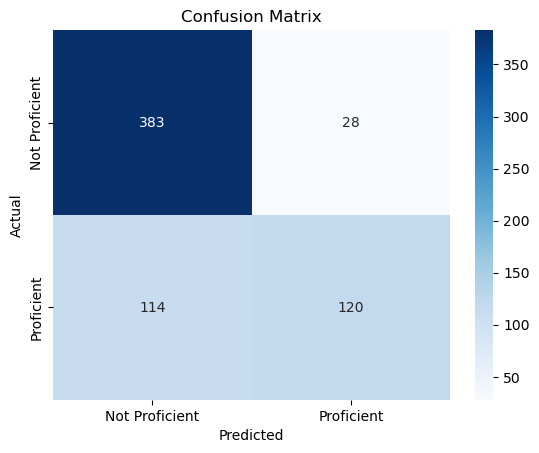

In [38]:
cm = confusion_matrix(y_test_bool, y_pred_bool)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Optionally, plot the confusion matrix using seaborn heatmap for better visualization
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Proficient", "Proficient"], yticklabels=["Not Proficient", "Proficient"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Feature Importance

In [39]:
importances = dt_model.feature_importances_
feature_names = X_train.columns

# Combine names and importances, and sort
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df= importance_df.sort_values(by='Importance', ascending=False)

# Display the sorted DataFrame
print(importance_df)

                  Feature  Importance
58    course_ChemistryAdv    0.414069
84      course_Enviro Sci    0.073901
156    course_Phy Sci Adv    0.043712
29     course_Algebra I B    0.034771
46      course_BullBogAdv    0.024613
40    course_BandConcer.5    0.024394
183   course_StudyHall912    0.020258
229   course_Yearbook9-12    0.018559
24     course_Alg II/Trig    0.015399
23    course_Alg Esntls B    0.014913
113    course_Health 9-12    0.014337
56    course_CareerPrep-B    0.014162
200    course_USHis InD-P    0.013989
131   course_LIFE PE 9-12    0.013449
196    course_US His-1877    0.012862
81    course_English Gr10    0.011854
215     course_Vis Arts I    0.011169
111   course_HISTUS1877AC    0.010874
7      course_ALIITRIGH/A    0.010191
55    course_CareerPrep-A    0.010127
177      course_Spanish 1    0.009765
132   course_LIFEPE9-12.5    0.009551
209        course_VarFBII    0.008746
234  school_High School D    0.007691
186      course_Theatre I    0.007540
3     course